In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torchmetrics import Accuracy
import torchmetrics

from timeit import default_timer as timer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001A95D412890>, <torch.utils.data.dataloader.DataLoader object at 0x000001A95D3FB090>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [6]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=output_shape,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x
        

In [7]:
def train_step(model:nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               device
               ):
    acc_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
    train_loss, train_acc = 0.0, 0.0
    model.to(device)
    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        y_results = y_pred.argmax(dim=1)
        train_loss += loss
        train_acc += acc_fn(y_results, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model:nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              device):
    acc_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
    test_loss, test_acc = 0.0, 0.0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += acc_fn(test_pred.argmax(dim=1), y)
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

* In Channels: Number of channels in the input image
* Out Channels: Number of channels produced by the convolution
* Kernel Size: size of the convolving filter
* Stride: How big of a step the convolving kernel takes at a time
* Padding: Padding added to all four sides of input

In [8]:
torch.manual_seed(42)
model = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [9]:
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

In [10]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [12]:
train_timer_begin = timer()
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_func,
        optimizer=optimizer,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_func,
        device=device
    )


Epoch: 0
---------
Train loss: 0.64378 | Train accuracy: 0.77%
Test loss: 0.40924 | Test accuracy: 0.85%

Epoch: 1
---------
Train loss: 0.37527 | Train accuracy: 0.87%
Test loss: 0.37919 | Test accuracy: 0.86%

Epoch: 2
---------
Train loss: 0.33312 | Train accuracy: 0.88%
Test loss: 0.40449 | Test accuracy: 0.86%



In [13]:
def make_predictions(model:torch.nn.Module, data:list, device:torch.device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [14]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [15]:
print(f'first sample\'s shape: {test_samples[0].shape}, label: {class_names[test_labels[0]]}')
print(f'second sample\'s shape: {test_samples[1].shape}, label: {class_names[test_labels[1]]}')

first sample's shape: torch.Size([1, 28, 28]), label: Sandal
second sample's shape: torch.Size([1, 28, 28]), label: Trouser


In [16]:
pred_probs = make_predictions(model, data=test_samples)
pred_probs.shape

torch.Size([9, 10])

In [17]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

In [18]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

c:\venv\torch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Making predictions: 100%|██████████| 313/313 [00:01<00:00, 197.19it/s]


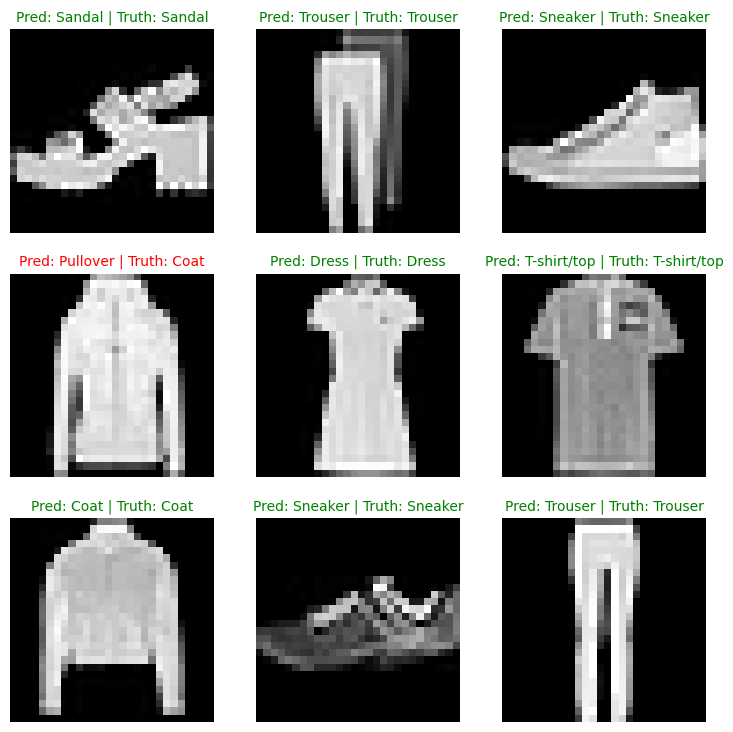

In [20]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)